In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops 

from collections import Counter 
import pandas as pd
import numpy as np
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


<h2><i>Dataset Preprocessing</i></h2>

In [3]:
# dir path for sample dataset
dir_path = os.getcwd() 
genuine_path = dir_path + '\\sample dataset\\sample_Signature\\genuine\\'
forged_path = dir_path + '\\sample dataset\\sample_Signature\\forged\\'
forged_class_path = dir_path + '\\sample dataset\\sample_Signature\\forged_classification\\'

In [4]:
X = []
Y = []

x_true = []
x_false = []

In [5]:
for folderName, subfolders, filenames in os.walk(genuine_path):
    for filename in filenames:
        print(filename)
        if(filename[9:12] == '001'):
            temp_img = image.load_img(genuine_path+filename,target_size=(224,224))
            temp_img = image.img_to_array(temp_img)
            X.append(temp_img)
            x_true.append(temp_img)
            Y.append(1)
        else:
            break
for folderName,subfolders,filenames in os.walk(forged_class_path+'NFI-XXXYY001\\'):
    for filename in filenames:
        print(filename)
        temp_img = image.load_img(forged_class_path+'NFI-XXXYY001\\'+filename,target_size=(224,224))
        temp_img = image.img_to_array(temp_img)
        X.append(temp_img)
        x_false.append(temp_img)
        Y.append(0)

NFI-00101001.png
NFI-00102001.png
NFI-00103001.png
NFI-00104001.png
NFI-00105001.png
NFI-00201002.png
NFI-00301001.png
NFI-00302001.png
NFI-00303001.png
NFI-00304001.png
NFI-00305001.png


In [6]:
x_true = np.array(x_true)
x_false = np.array(x_false)

In [7]:
x_true.shape

(5, 224, 224, 3)

In [8]:
x_false.shape

(5, 224, 224, 3)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen_true = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=False,
        fill_mode='nearest')

datagen_false = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=False,
        fill_mode='nearest')
datagen_true.fit(x_true)
datagen_false.fit(x_false)

In [10]:
i = 0
for batch in datagen_true.flow(x_true, y=None):
    i = i + 1
    if i >= 9:
        break
    print(batch.shape)
    for img in batch:
        X.append(img)
        Y.append(1)

(5, 224, 224, 3)
(5, 224, 224, 3)
(5, 224, 224, 3)
(5, 224, 224, 3)
(5, 224, 224, 3)
(5, 224, 224, 3)
(5, 224, 224, 3)
(5, 224, 224, 3)


In [11]:
i = 0
for batch in datagen_true.flow(x_false, y=None, batch_size=32):
    i = i + 1
    if i >= 9:
        break
    for img in batch:
        X.append(img)
        Y.append(0)

In [12]:
X = np.array(X)
Y = np.array(Y)

In [13]:
X.shape

(90, 224, 224, 3)

In [14]:
X /= 255

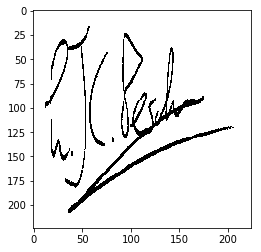

In [15]:
plt.imshow(X[8])

In [16]:
from sklearn.model_selection import train_test_split
train_x, x, train_y, y = train_test_split(X, Y, test_size = 0.2, random_state = 1)
test_x, val_x, test_y, val_y = train_test_split(x, y, test_size = 0.5, random_state = 1)

In [17]:
test_x.shape

(9, 224, 224, 3)

<h2> <i> Model Structure </i> </h2>

In [18]:
# vgg16 model 
model_vgg = VGG16(weights='imagenet', include_top=False)

In [19]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [20]:
features_train = model_vgg.predict(train_x)
features_val = model_vgg.predict(val_x)

In [21]:
features_val.shape

(9, 7, 7, 512)

In [22]:
Train_x = features_train.reshape(72,25088)
Val_x = features_val.reshape(9,25088)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model=Sequential()

In [24]:
# predicting model 
model.add(Dense(1000,input_dim=25088,activation='relu',kernel_initializer='uniform'))
model.add(Dense(100,input_dim=1000,activation='relu',kernel_initializer='uniform'))
model.add(Dense(10,input_dim=100,activation='relu',kernel_initializer='uniform'))
model.add(Dense(units=2))
model.add(Activation('sigmoid'))
model.compile(loss='mean_squared_error',optimizer="adam",metrics=['accuracy'])


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              25089000  
_________________________________________________________________
dense_2 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 25,190,132
Trainable params: 25,190,132
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.utils.np_utils import to_categorical
Train_Y = to_categorical(train_y,num_classes=2)
Val_Y = to_categorical(val_y,num_classes=2)
Test_Y = to_categorical(test_y,num_classes=2)


In [27]:
model.fit(Train_x, Train_Y, epochs=10,batch_size=16,validation_data=(Val_x,Val_Y))

Train on 72 samples, validate on 9 samples
Epoch 1/10
72/72 [==============================] - 4s 51ms/step - loss: 0.1562 - acc: 0.8056 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 2/10
72/72 [==============================] - 0s 3ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 6.7340e-06 - val_acc: 1.0000
Epoch 3/10
72/72 [==============================] - 0s 4ms/step - loss: 5.1723e-05 - acc: 1.0000 - val_loss: 7.4170e-05 - val_acc: 1.0000
Epoch 4/10
72/72 [==============================] - 0s 4ms/step - loss: 7.7553e-05 - acc: 1.0000 - val_loss: 3.7308e-05 - val_acc: 1.0000
Epoch 5/10
72/72 [==============================] - 0s 3ms/step - loss: 4.1071e-05 - acc: 1.0000 - val_loss: 1.5958e-05 - val_acc: 1.0000
Epoch 6/10
72/72 [==============================] - 0s 3ms/step - loss: 1.0875e-05 - acc: 1.0000 - val_loss: 6.9313e-06 - val_acc: 1.0000
Epoch 7/10
72/72 [==============================] - 0s 3ms/step - loss: 3.7602e-06 - acc: 1.0000 - val_loss: 2.1545e-06 - val_acc: 1.0000
Ep

In [28]:
test_x.shape

(9, 224, 224, 3)

In [29]:
features_test = model_vgg.predict(test_x)

In [30]:
features_test.shape

(9, 7, 7, 512)

In [31]:
Test_X = features_test.reshape(9,25088)

In [32]:
Test_X.shape

(9, 25088)

In [33]:
predict_class = model.predict(Test_X)

In [34]:
predict_class.shape

(9, 2)

In [39]:
predict_class[8]

array([9.999999e-01, 7.016018e-06], dtype=float32)

In [40]:
Test_Y[8]

array([1., 0.], dtype=float32)

In [42]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")